## Bernstein Vazirani Algorithm
#### In this tutorial, we will demonstrate the capabilities of qBraid Algorithms Bernstein Vazirani Module
Begin by importing the module from qBraid Algorithms library

In [2]:
import pyqasm
from qbraid_algorithms import bernstein_vazirani as bv

To load a full Bernstein Vazirani algorithm circuit as a PyQASM module, simply pass the secret string to be encoded in the oracle to the `load_program()` method.

In [3]:
module = bv.load_program("1011")

We can perform all standard [PyQASM](https://docs.qbraid.com/pyqasm/user-guide/overview) operations on the module, such as unrolling.

In [4]:
module.unroll()

Below, we display the unrolled circuit, which includes preparing the input and ancilla qubits, applying the '1011' oracle, applying Hadamard gates after the oracle, then measuring the results.

In [5]:
module_str = pyqasm.dumps(module)
print(module_str)

OPENQASM 3.0;
include "stdgates.inc";
qubit[1] ancilla;
qubit[4] q;
bit[4] b;
h q[0];
h q[1];
h q[2];
h q[3];
x ancilla[0];
h ancilla[0];
cx q[0], ancilla[0];
cx q[2], ancilla[0];
cx q[3], ancilla[0];
h q[0];
h q[1];
h q[2];
h q[3];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];
b[3] = measure q[3];



## Using B-V in your own OpenQASM3 program
#### qBraid algorithms makes it easy to incorporate either the full Bernstein Vazirani algorithm - or just the encoded oracle - into your own OpenQASM3 circuit.
To use a secret string-encoded oracle in your circuit, first generate the oracle submodule using the `generate_oracle` method, which takes a secret string. The method will create a QASM3 file containing your oracle as a subroutine within your current working directory.

In [6]:
bv.generate_oracle("111")

Oracle 'oracle' has been added to /Users/lukeandreesen/qbraid_algos/examples/oracle.qasm


Below, we can see the custom oracle subroutine that you now have access to. To use this in your own circuit, simply add `include "oracle.qasm";` to your OpenQASM file, and call the `oracle` subroutine by passing an appropriately sized register of qubits and an ancilla qubit.

In [7]:
%cat oracle.qasm

OPENQASM 3.0;
include "stdgates.inc";

def oracle(qubit[3] q, qubit[1] ancilla) {
    int[32] s = 7;
    int[16] n = 3;
    for int i in [0:n - 1] {
        if ((s >> i) & 1) {
            cx q[i], ancilla[0];
        }
    }
}


Similarly, you can generate an entire Bernstein Vazirani circuit as a submodule using the `generate_subroutine` method, again passing your desired secret string.

In [8]:
subroutine = bv.generate_subroutine("011")

Subroutine 'bernvaz' has been added to /Users/lukeandreesen/qbraid_algos/examples/bernvaz.qasm


To use the subroutine in your own circuit, add `include "bernvaz.qasm";` to your OpenQASM file, and call the `bernvaz` method by passing an appropriately sized register of qubits, as well as an ancilla qubit.

In [9]:
%cat bernvaz.qasm

OPENQASM 3.0;
include "stdgates.inc";

def bernvaz(qubit[3] q, qubit[1] ancilla) {
    int[32] s = 6;
    int[16] n = 3;
    for int i in [0:n - 1] {
        h q[i];
    }
    x ancilla[0];
    h ancilla[0];
    // Note: Nested subroutine calls not yet supported by QASM, so manually insert
    for int i in [0:n - 1] {
        if ((s >> i) & 1) {
            cx q[i], ancilla[0];
        }
    }
    for int i in [0:n - 1] {
        h q[i];
    }

}


## Running Algorithms on qBraid
Running algorithms on qBraid is simple. First, import QbraidProvider from qBraid Runtime. Visit [here](https://docs.qbraid.com/sdk/user-guide/providers/native#qbraidprovider) for more information.

In [10]:
from qbraid.runtime import QbraidProvider

/opt/homebrew/lib/python3.11/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.4.30 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


If you have not yet configured QbraidProvider, provide your API key.

In [11]:
# provider = QbraidProvider(api_key='API_KEY')
provider = QbraidProvider()

We'll run our program on qBraid's QIR simulator.

In [12]:
device = provider.get_device("qbraid_qir_simulator")

To run the job, simply pass a QASM string to the device. If you have a PyQASM module, use `dumps` to generate a QASM string

In [13]:
secret_string = "101"
module = bv.load_program(secret_string)
module.unroll()
qasm_str = pyqasm.dumps(module)
print(qasm_str)

OPENQASM 3.0;
include "stdgates.inc";
qubit[1] ancilla;
qubit[3] q;
bit[3] b;
h q[0];
h q[1];
h q[2];
x ancilla[0];
h ancilla[0];
cx q[0], ancilla[0];
cx q[2], ancilla[0];
h q[0];
h q[1];
h q[2];
b[0] = measure q[0];
b[1] = measure q[1];
b[2] = measure q[2];



In [14]:
job = device.run(qasm_str, shots=500)

We can now get the counts from the job results.

In [15]:
results = job.result()
counts = results.data.get_counts()

{'1010': 500}


We can now check the counts to see if the most frequent value is our secret string. This particular backend includes the ancilla qubit as the least significant bit, so we'll remove that.

In [21]:
# Remove ancilla qubit from bitstring
processed_counts = {bitstr[:-1]: count for bitstr, count in counts.items()}
# Find most frequent count
max_str = max(processed_counts, key=counts.get)

print(f"Secret String: {secret_string}. B-V result string: {result_string}")

Secret String: 101. B-V result string: 101


We see that the algorithm successfully identified the secret string. Finally, we can plot the results using qBraid Visualization.

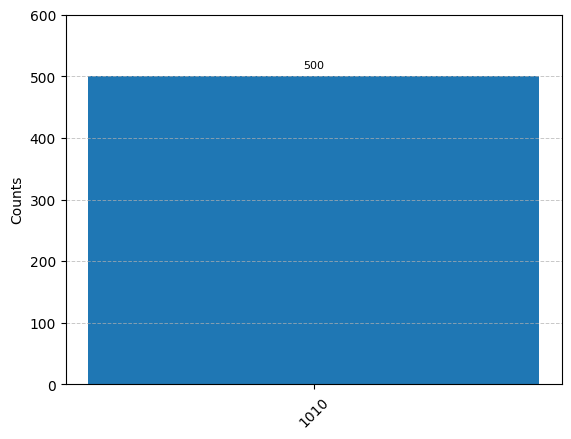

In [17]:
from qbraid.visualization import plot_histogram

plot_histogram(counts)